# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [3]:
# Check for GPU
!nvidia-smi

Sun Oct  1 21:26:32 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8               2W /  50W |    125MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.2.0.dev20230910+cu121


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

* 1. Add more hidden units or layers
  2. Train for longer
  3. Tweak the learning rate

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [5]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"Directory already exists...")
else:
    print(f"Creating directory...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download the data
try:    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        
        # Check if download was successful (status code 200)
        if request.status_code == 200:
            print("Downloading data...")
            f.write(request.content)
            print("Download complete!")
        else:
            print(f"Failed to download. Status code: {request.status_code}")
except Exception as e:
    print(f"An error occurred: {str(e)}")

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, and sushi data...")
    zip_ref.extractall(image_path)

Directory already exists...
Download complete!
Unzipping pizza, steak, and sushi data...


In [6]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

Image class: pizza


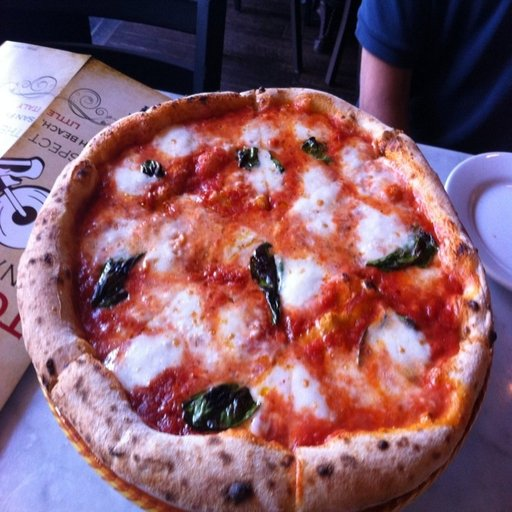

In [9]:
# Visualize an image
import random
from PIL import Image

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get a random image
random_image_path = random.choice(image_path_list)
random_image_path

# 3. Get class name
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print image
print(f"Image class: {image_class}")
img

(-0.5, 511.5, 511.5, -0.5)

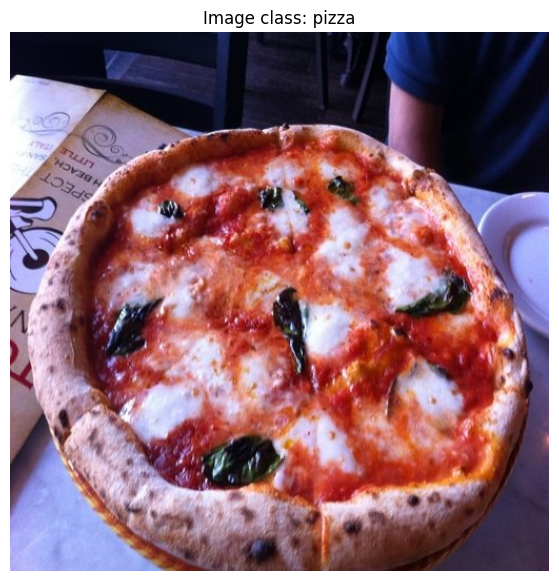

In [10]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}")
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [11]:
# 3.1 Transforming data with torchvision.transforms
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [12]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

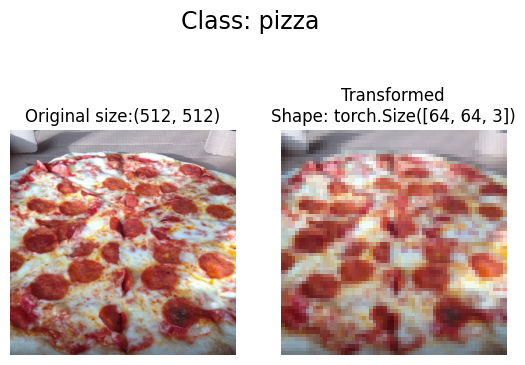

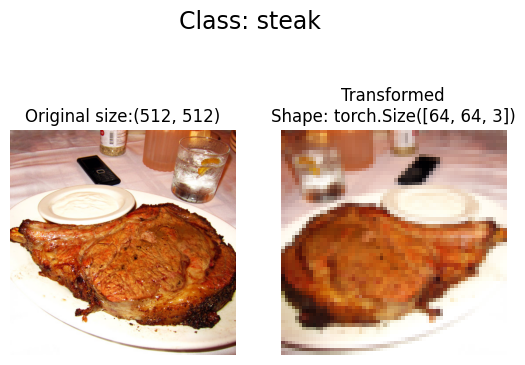

In [13]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            
            # Original image
            ax[0].imshow(f)
            ax[0].set_title(f"Original size:{f.size}")
            ax[0].axis(False)

            # Transformed image
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=17)

plot_transformed_images(image_paths=image_path_list, transform=data_transform, n=2, seed=17)

### Load image data using `ImageFolder`

In [14]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,
)

In [15]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
# Turn train and test Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE =32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True
)
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=False
)

In [19]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(8, 3)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [20]:
import torch
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)           
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x):
        return self.classifier(self.conv_block2(self.conv_block1(x)))

## 4. Create training and testing functions for `model_0`.

In [21]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device="cuda"):

  # Put the model in train mode
    model.train()

  # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
    for batch, (X,y) in enumerate(dataloader):
    # Send data to target device
        X, y = X.to(device), y.to(device)
    # 1. Forward pass
        y_pred = model(X)
        
    # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss +=loss.item()
    # 3. Optimizer zero grad
        optimizer.zero_grad()

    # 4. Loss backward
        loss.backward()

    # 5. Optimizer step
        optimizer.step()

    # Calculate and accumulate accuracy metric across all batches
        y_pred_labels = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_labels==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

In [22]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device="cuda"):

  # Put model in eval mode
    model.eval()

  # Setup the test loss and test accuracy values
    test_loss, test_acc = 0, 0

  # Turn on inference context manager
    with torch.inference_mode():
    # Loop through DataLoader batches
        for batch, (X,y) in enumerate(dataloader):
      # Send data to target device
            X, y = X.to(device), y.to(device)
            
      # 1. Forward pass
            test_pred = model(X)

      # 2. Calculuate and accumulate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
      # Calculate and accumulate accuracy
            test_pred_labels = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_labels==y).sum().item()/len(test_pred)

  # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

In [23]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

/home/gerald/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [24]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)
train(model=model_0,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn)

 20%|█████████                                    | 1/5 [00:02<00:09,  2.34s/it]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3125 | test_loss: 1.0989 | test_acc: 0.3021


 40%|██████████████████                           | 2/5 [00:03<00:05,  1.78s/it]

Epoch: 2 | train_loss: 1.0993 | train_acc: 0.3320 | test_loss: 1.0693 | test_acc: 0.5417


 60%|███████████████████████████                  | 3/5 [00:04<00:03,  1.54s/it]

Epoch: 3 | train_loss: 1.0865 | train_acc: 0.3555 | test_loss: 1.0803 | test_acc: 0.4517


 80%|████████████████████████████████████         | 4/5 [00:06<00:01,  1.45s/it]

Epoch: 4 | train_loss: 1.0848 | train_acc: 0.3828 | test_loss: 1.0572 | test_acc: 0.5938


100%|█████████████████████████████████████████████| 5/5 [00:07<00:00,  1.55s/it]

Epoch: 5 | train_loss: 1.0622 | train_acc: 0.4023 | test_loss: 1.0667 | test_acc: 0.4631


{'train_loss': [1.1062811762094498,
  1.0993257015943527,
  1.086547151207924,
  1.0847894251346588,
  1.0622371137142181],
 'train_acc': [0.3125, 0.33203125, 0.35546875, 0.3828125, 0.40234375],
 'test_loss': [1.098851203918457,
  1.069283167521159,
  1.080342173576355,
  1.0572103261947632,
  1.0667246182759602],
 'test_acc': [0.3020833333333333,
  0.5416666666666666,
  0.4517045454545454,
  0.59375,
  0.4630681818181818]}

In [25]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)
train(model=model_1,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=20)

  5%|██▏                                         | 1/20 [00:01<00:27,  1.46s/it]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3125 | test_loss: 1.0989 | test_acc: 0.3021


 10%|████▍                                       | 2/20 [00:02<00:26,  1.46s/it]

Epoch: 2 | train_loss: 1.0993 | train_acc: 0.3320 | test_loss: 1.0693 | test_acc: 0.5417


 15%|██████▌                                     | 3/20 [00:04<00:24,  1.43s/it]

Epoch: 3 | train_loss: 1.0865 | train_acc: 0.3555 | test_loss: 1.0803 | test_acc: 0.4517


 20%|████████▊                                   | 4/20 [00:05<00:23,  1.45s/it]

Epoch: 4 | train_loss: 1.0849 | train_acc: 0.3828 | test_loss: 1.0571 | test_acc: 0.5938


 25%|███████████                                 | 5/20 [00:07<00:22,  1.47s/it]

Epoch: 5 | train_loss: 1.0622 | train_acc: 0.4062 | test_loss: 1.0670 | test_acc: 0.4631


 30%|█████████████▏                              | 6/20 [00:08<00:20,  1.47s/it]

Epoch: 6 | train_loss: 1.0259 | train_acc: 0.4609 | test_loss: 1.0124 | test_acc: 0.4934


 35%|███████████████▍                            | 7/20 [00:10<00:18,  1.43s/it]

Epoch: 7 | train_loss: 0.9761 | train_acc: 0.4336 | test_loss: 0.9295 | test_acc: 0.5833


 40%|█████████████████▌                          | 8/20 [00:11<00:16,  1.40s/it]

Epoch: 8 | train_loss: 0.9494 | train_acc: 0.5820 | test_loss: 1.0171 | test_acc: 0.4441


 45%|███████████████████▊                        | 9/20 [00:12<00:15,  1.41s/it]

Epoch: 9 | train_loss: 0.9215 | train_acc: 0.5859 | test_loss: 1.0690 | test_acc: 0.3324


 50%|█████████████████████▌                     | 10/20 [00:14<00:14,  1.40s/it]

Epoch: 10 | train_loss: 1.0040 | train_acc: 0.4648 | test_loss: 1.0583 | test_acc: 0.3835


 55%|███████████████████████▋                   | 11/20 [00:15<00:12,  1.44s/it]

Epoch: 11 | train_loss: 0.8932 | train_acc: 0.5195 | test_loss: 0.9811 | test_acc: 0.4830


 60%|█████████████████████████▊                 | 12/20 [00:17<00:11,  1.38s/it]

Epoch: 12 | train_loss: 0.9379 | train_acc: 0.4570 | test_loss: 0.9332 | test_acc: 0.5540


 65%|███████████████████████████▉               | 13/20 [00:18<00:09,  1.38s/it]

Epoch: 13 | train_loss: 0.7901 | train_acc: 0.6445 | test_loss: 0.9807 | test_acc: 0.4536


 70%|██████████████████████████████             | 14/20 [00:19<00:08,  1.39s/it]

Epoch: 14 | train_loss: 0.8939 | train_acc: 0.5156 | test_loss: 1.0524 | test_acc: 0.4138


 75%|████████████████████████████████▎          | 15/20 [00:21<00:06,  1.39s/it]

Epoch: 15 | train_loss: 0.7895 | train_acc: 0.6953 | test_loss: 0.9847 | test_acc: 0.4934


 80%|██████████████████████████████████▍        | 16/20 [00:22<00:05,  1.35s/it]

Epoch: 16 | train_loss: 0.7417 | train_acc: 0.6914 | test_loss: 0.9857 | test_acc: 0.4934


 85%|████████████████████████████████████▌      | 17/20 [00:24<00:04,  1.43s/it]

Epoch: 17 | train_loss: 0.7786 | train_acc: 0.6914 | test_loss: 1.0166 | test_acc: 0.4233


 90%|██████████████████████████████████████▋    | 18/20 [00:29<00:05,  2.54s/it]

Epoch: 18 | train_loss: 0.7613 | train_acc: 0.6484 | test_loss: 1.0493 | test_acc: 0.4536


 95%|████████████████████████████████████████▊  | 19/20 [00:30<00:02,  2.22s/it]

Epoch: 19 | train_loss: 0.7827 | train_acc: 0.7031 | test_loss: 1.0326 | test_acc: 0.4744


100%|███████████████████████████████████████████| 20/20 [00:32<00:00,  1.60s/it]

Epoch: 20 | train_loss: 0.8025 | train_acc: 0.6406 | test_loss: 1.0441 | test_acc: 0.4337


{'train_loss': [1.1062811762094498,
  1.0993243604898453,
  1.0865481197834015,
  1.0848715603351593,
  1.0622350871562958,
  1.0259411334991455,
  0.9760761857032776,
  0.9494048953056335,
  0.9215285256505013,
  1.0040420815348625,
  0.8931905701756477,
  0.9379161670804024,
  0.7900950275361538,
  0.8938824236392975,
  0.7895011231303215,
  0.741682879626751,
  0.7785937041044235,
  0.7612756416201591,
  0.7826775684952736,
  0.8025417700409889],
 'train_acc': [0.3125,
  0.33203125,
  0.35546875,
  0.3828125,
  0.40625,
  0.4609375,
  0.43359375,
  0.58203125,
  0.5859375,
  0.46484375,
  0.51953125,
  0.45703125,
  0.64453125,
  0.515625,
  0.6953125,
  0.69140625,
  0.69140625,
  0.6484375,
  0.703125,
  0.640625],
 'test_loss': [1.098851203918457,
  1.069286306699117,
  1.0803389151891072,
  1.0571123758951824,
  1.0670117139816284,
  1.0124285419782002,
  0.9294967651367188,
  1.0171493291854858,
  1.0690157612164815,
  1.0582656264305115,
  0.9811094204584757,
  0.9332332611083

In [26]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(#TODO,
                             lr=0.001)

NameError: name 'model_' is not defined

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [27]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_doubled = TinyVGG(input_shape=3,
                        hidden_units=20,
                        output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_doubled.parameters(),
                             lr=0.001)
train(model=model_doubled,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      epochs=20)

  5%|██▏                                         | 1/20 [00:01<00:28,  1.52s/it]

Epoch: 1 | train_loss: 1.1038 | train_acc: 0.2773 | test_loss: 1.1014 | test_acc: 0.1979


 10%|████▍                                       | 2/20 [00:02<00:25,  1.41s/it]

Epoch: 2 | train_loss: 1.0998 | train_acc: 0.2852 | test_loss: 1.0966 | test_acc: 0.3021


 15%|██████▌                                     | 3/20 [00:04<00:24,  1.45s/it]

Epoch: 3 | train_loss: 1.0959 | train_acc: 0.2891 | test_loss: 1.0743 | test_acc: 0.2604


 20%|████████▊                                   | 4/20 [00:05<00:23,  1.46s/it]

Epoch: 4 | train_loss: 1.1159 | train_acc: 0.3047 | test_loss: 1.0957 | test_acc: 0.2604


 25%|███████████                                 | 5/20 [00:07<00:21,  1.45s/it]

Epoch: 5 | train_loss: 1.0828 | train_acc: 0.4805 | test_loss: 1.1066 | test_acc: 0.2188


 30%|█████████████▏                              | 6/20 [00:08<00:19,  1.40s/it]

Epoch: 6 | train_loss: 1.0703 | train_acc: 0.4258 | test_loss: 1.1263 | test_acc: 0.2188


 35%|███████████████▍                            | 7/20 [00:09<00:17,  1.36s/it]

Epoch: 7 | train_loss: 1.0506 | train_acc: 0.4492 | test_loss: 1.1098 | test_acc: 0.3125


 40%|█████████████████▌                          | 8/20 [00:11<00:17,  1.42s/it]

Epoch: 8 | train_loss: 0.9815 | train_acc: 0.5430 | test_loss: 1.0942 | test_acc: 0.3220


 45%|███████████████████▊                        | 9/20 [00:12<00:15,  1.43s/it]

Epoch: 9 | train_loss: 0.9231 | train_acc: 0.5586 | test_loss: 1.3088 | test_acc: 0.2812


 50%|█████████████████████▌                     | 10/20 [00:18<00:26,  2.64s/it]

Epoch: 10 | train_loss: 1.0791 | train_acc: 0.4844 | test_loss: 1.0224 | test_acc: 0.4318


 55%|███████████████████████▋                   | 11/20 [00:19<00:20,  2.26s/it]

Epoch: 11 | train_loss: 0.9368 | train_acc: 0.5664 | test_loss: 0.9584 | test_acc: 0.5938


 60%|█████████████████████████▊                 | 12/20 [00:20<00:15,  1.98s/it]

Epoch: 12 | train_loss: 0.9565 | train_acc: 0.5586 | test_loss: 0.9565 | test_acc: 0.5739


 65%|███████████████████████████▉               | 13/20 [00:22<00:12,  1.81s/it]

Epoch: 13 | train_loss: 0.8993 | train_acc: 0.4570 | test_loss: 0.9693 | test_acc: 0.3816


 70%|██████████████████████████████             | 14/20 [00:23<00:10,  1.68s/it]

Epoch: 14 | train_loss: 0.8474 | train_acc: 0.5352 | test_loss: 1.1280 | test_acc: 0.3428


 75%|████████████████████████████████▎          | 15/20 [00:25<00:08,  1.62s/it]

Epoch: 15 | train_loss: 1.1775 | train_acc: 0.5039 | test_loss: 1.0498 | test_acc: 0.3731


 80%|██████████████████████████████████▍        | 16/20 [00:26<00:06,  1.60s/it]

Epoch: 16 | train_loss: 0.8275 | train_acc: 0.5195 | test_loss: 0.9241 | test_acc: 0.5445


 85%|████████████████████████████████████▌      | 17/20 [00:28<00:04,  1.62s/it]

Epoch: 17 | train_loss: 0.8193 | train_acc: 0.5664 | test_loss: 0.9424 | test_acc: 0.5038


 90%|██████████████████████████████████████▋    | 18/20 [00:33<00:05,  2.64s/it]

Epoch: 18 | train_loss: 0.8901 | train_acc: 0.5078 | test_loss: 1.0482 | test_acc: 0.4347


 95%|████████████████████████████████████████▊  | 19/20 [00:34<00:02,  2.28s/it]

Epoch: 19 | train_loss: 0.8318 | train_acc: 0.6055 | test_loss: 0.9159 | test_acc: 0.5559


100%|███████████████████████████████████████████| 20/20 [00:36<00:00,  1.82s/it]

Epoch: 20 | train_loss: 0.7291 | train_acc: 0.6836 | test_loss: 0.9153 | test_acc: 0.5256


{'train_loss': [1.1037504971027374,
  1.099826842546463,
  1.0959234237670898,
  1.1159066706895828,
  1.0827921330928802,
  1.0702858865261078,
  1.0505783185362816,
  0.9815169647336006,
  0.9231365993618965,
  1.0790533423423767,
  0.9368439093232155,
  0.9564878195524216,
  0.8993327990174294,
  0.8473724573850632,
  1.1775326654314995,
  0.8274936750531197,
  0.8192555047571659,
  0.8901309669017792,
  0.8318328782916069,
  0.7291233581490815],
 'train_acc': [0.27734375,
  0.28515625,
  0.2890625,
  0.3046875,
  0.48046875,
  0.42578125,
  0.44921875,
  0.54296875,
  0.55859375,
  0.484375,
  0.56640625,
  0.55859375,
  0.45703125,
  0.53515625,
  0.50390625,
  0.51953125,
  0.56640625,
  0.5078125,
  0.60546875,
  0.68359375],
 'test_loss': [1.101442575454712,
  1.096603274345398,
  1.0743213494618733,
  1.0956567923227947,
  1.106632113456726,
  1.126348336537679,
  1.1098238825798035,
  1.0941527287165325,
  1.30883127450943,
  1.0224233865737915,
  0.9584234356880188,
  0.9565

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

In [29]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.


Excellent, we now have double the training and testing images...

In [30]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [31]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
# Create datasets
train_data = datasets.ImageFolder(root=train_data_20_percent_path,
                                  transform=simple_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_data_20_percent_path,
                                 transform=simple_transform,
                                 target_transform=None)

# Create dataloaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

In [32]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_20_percent_data = TinyVGG(input_shape=3,
                                hidden_units=10,
                                output_shape=len(class_names)).to(device)

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_20_percent_data.parameters(),
                             lr=0.0002)


train(model=model_20_percent_data,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      epochs=3)

 33%|███████████████                              | 1/3 [00:01<00:03,  1.64s/it]

Epoch: 1 | train_loss: 0.8534 | train_acc: 0.6188 | test_loss: 0.9331 | test_acc: 0.5852


 67%|██████████████████████████████               | 2/3 [00:03<00:01,  1.55s/it]

Epoch: 2 | train_loss: 0.8866 | train_acc: 0.6292 | test_loss: 0.9335 | test_acc: 0.5790


100%|█████████████████████████████████████████████| 3/3 [00:04<00:00,  1.55s/it]

Epoch: 3 | train_loss: 0.8384 | train_acc: 0.6646 | test_loss: 0.9338 | test_acc: 0.5790


{'train_loss': [0.8534377654393513, 0.8866459767023722, 0.8384135524431865],
 'train_acc': [0.61875, 0.6291666666666667, 0.6645833333333333],
 'test_loss': [0.9330917239189148, 0.9334925651550293, 0.9337606787681579],
 'test_acc': [0.5852272727272727, 0.5789772727272727, 0.5789772727272727]}

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [41]:
import torchvision

custom_image_path = data_path / "pizza-custom.jpg"

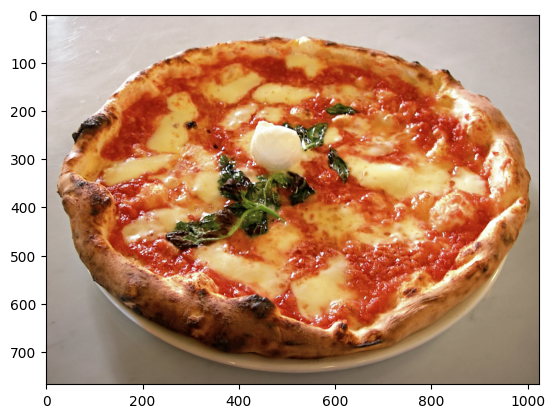

In [46]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.0
plt.imshow(custom_image.permute(1,2,0))                                         

In [72]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

custom_image_transformed = simple_transform(custom_image)

model_20_percent_data.eval()
with torch.inference_mode():
    pred_label = model_20_percent_data(custom_image_transformed.unsqueeze(0).to(device))
    pred_class = class_names[int(pred_label.argmax().item())]

prediction_correct = "correct" if pred_class == "pizza" else "incorrect"
print(f"Prediction is: {pred_class} and this is " + prediction_correct)


Prediction is: pizza and this is correct


In [66]:
type(pred_class)

str